In [27]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings
sys.path.append("../")

import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np

import imodels
from imodels.util.data_util import get_clean_dataset
from imodels.experimental import FIGSExtClassifier

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
# while os.getcwd().split('/')[-1] != 'imodels-experiments':
#     os.chdir('..')

# from config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from viz import *

# print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        #         stats = sklearn.metrics.classification_report(y_test, preds,
        #                                                       output_dict=True,
        #                                                       zero_division=0)

        #         all_stats['sensitivity'].append(stats['1']['recall'])
        #         all_stats['specificity'].append(stats['0']['recall'])
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        plt.plot(all_stats['sens'], all_stats['spec'], '.-')
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

# print(sklearn.metrics.classification_report(y_test, preds))

In [11]:
rules_grid = [5, 7, 10, 15]

# 1. IAI model

In [42]:
dataset = "iai"
X, y, feature_names = get_clean_dataset(f'{dataset}_pecarn_pred.csv', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=405)
sample_weight = np.ones_like(y_train)
# sample_weight[y_train == 1] = (1 - y.mean()) / y.mean()

In [43]:
iai_models = {"figs": [],
              "cart": []}
for n_rules in rules_grid:
    m = imodels.FIGSClassifier(max_rules=n_rules)
    cart = DecisionTreeClassifier(max_leaf_nodes=n_rules)
    m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)
    cart.fit(X_train, y_train, sample_weight=sample_weight)
    iai_models["figs"].append(m)
    iai_models["cart"].append(cart)

In [44]:
iai_scores = {"max_rules": rules_grid,
              "figs": [],
              "cart": []}
for idx, n_rules in enumerate(rules_grid):
    m = iai_models["figs"][idx]
    cart = iai_models["cart"][idx]
    figs_score = metrics.roc_auc_score(y_test, m.predict_proba(X_test)[:,1])
    cart_score = metrics.roc_auc_score(y_test, cart.predict_proba(X_test)[:,1])
    iai_scores["figs"].append(figs_score)
    iai_scores["cart"].append(cart_score)
pd.DataFrame(iai_scores)

,max_rules,figs,cart
0,5,0.791494,0.778875
1,7,0.791581,0.780465
2,10,0.792397,0.779766
3,15,0.801304,0.742228


[Text(0.5, 0.875, 'AbdomenPain_no <= 0.5\ngini = 0.458\nsamples = 8430\nvalue = [8280, 15000]'),
 Text(0.25, 0.625, 'AbdTrauma_no <= 0.5\ngini = 0.352\nsamples = 3845\nvalue = [3719, 12600]'),
 Text(0.125, 0.375, 'gini = 0.182\nsamples = 897\nvalue = [824, 7300]'),
 Text(0.375, 0.375, 'GCSScore <= 10.5\ngini = 0.457\nsamples = 2948\nvalue = [2895, 5300]'),
 Text(0.25, 0.125, 'gini = 0.191\nsamples = 325\nvalue = [300, 2500]'),
 Text(0.5, 0.125, 'gini = 0.499\nsamples = 2623\nvalue = [2595, 2800]'),
 Text(0.75, 0.625, 'GCSScore_Full_no <= 0.5\ngini = 0.452\nsamples = 4585\nvalue = [4561, 2400]'),
 Text(0.625, 0.375, 'gini = 0.398\nsamples = 4244\nvalue = [4228, 1600]'),
 Text(0.875, 0.375, 'gini = 0.415\nsamples = 341\nvalue = [333, 800]')]

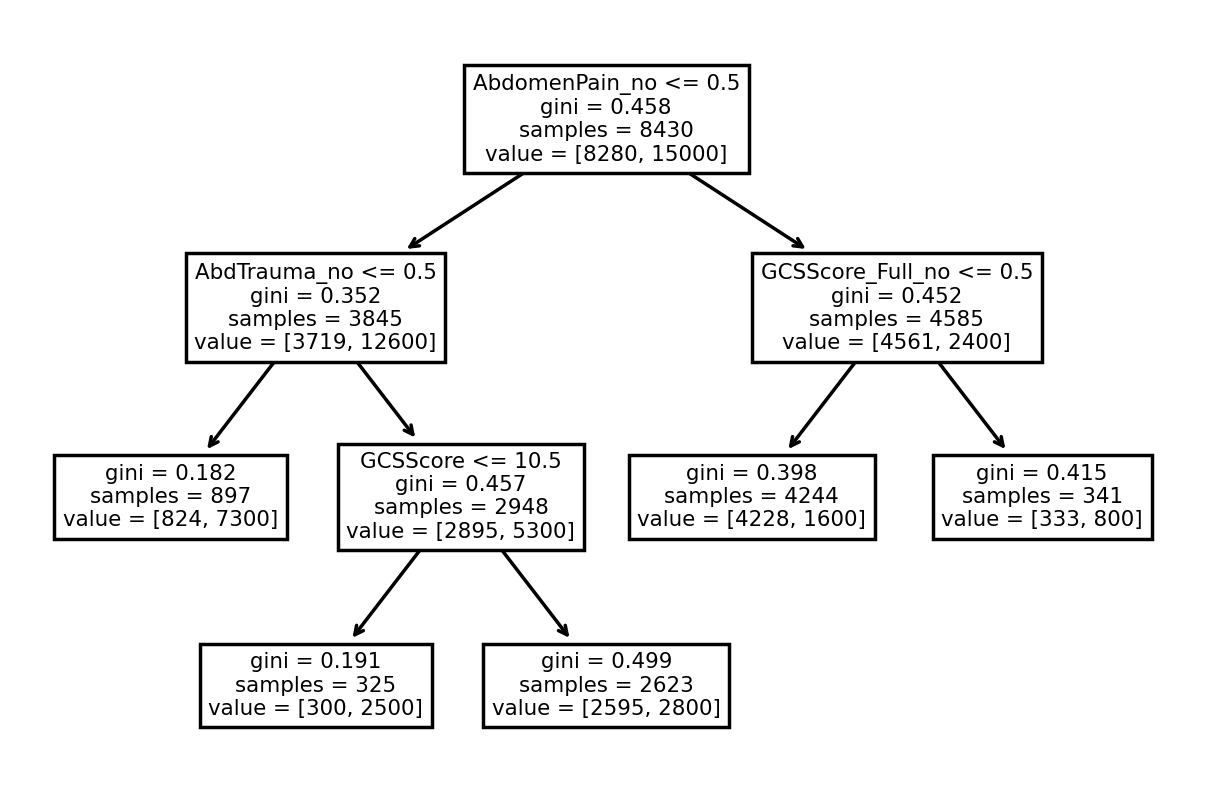

In [29]:
plot_tree(iai_models["cart"][0], feature_names=feature_names)

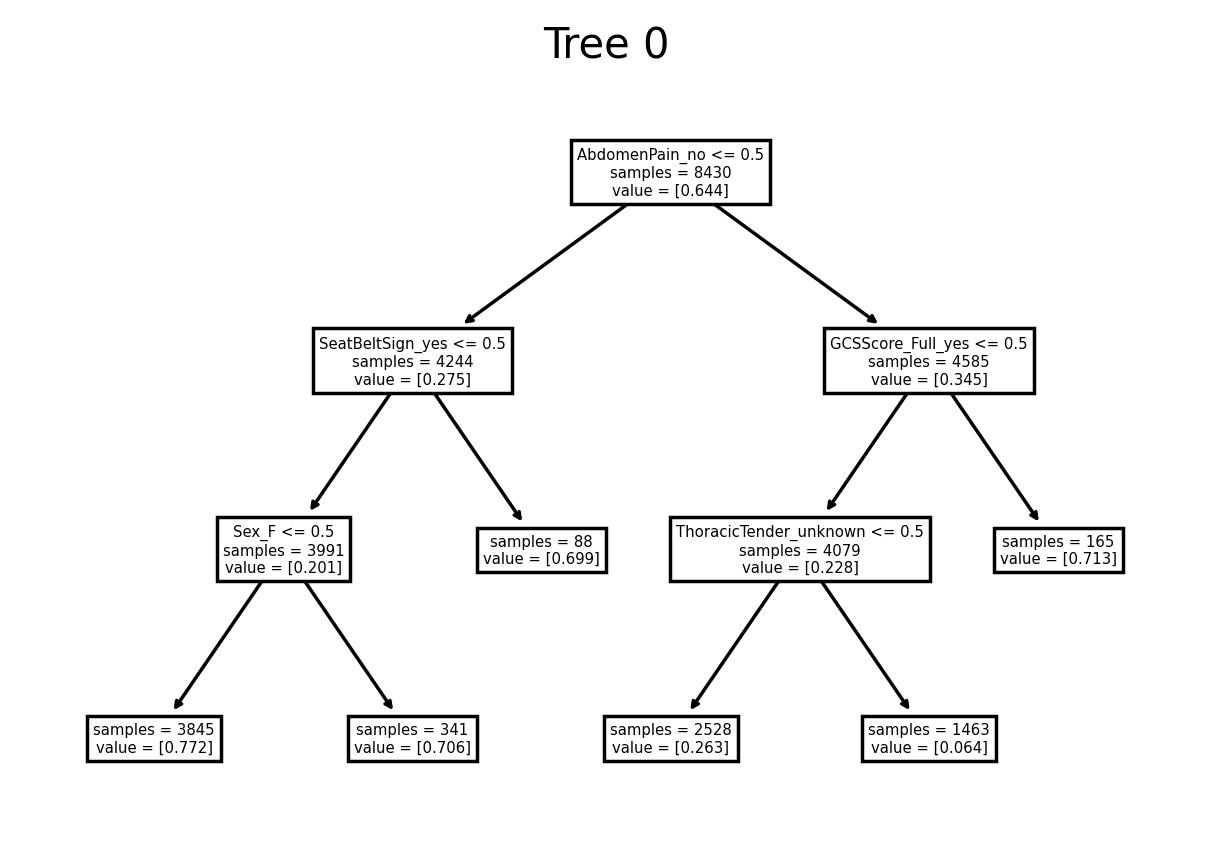

In [25]:
iai_models["figs"][0].plot(feature_names=feature_names)

In [30]:
# preds = m.predict_proba(X_test)[:, 1]
# all_stats_curve(y_test, preds, plot=True)

# 2. CSI model

In [45]:
dataset = "csi"
X, y, feature_names = get_clean_dataset(f'{dataset}_pecarn_pred.csv', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=405)
sample_weight = np.ones_like(y_train)
sample_weight[y_train == 1] = (1 - y.mean()) / y.mean()

In [46]:
csi_models = {"figs": [],
              "cart": []}
for n_rules in rules_grid:
    m = imodels.FIGSClassifier(max_rules=n_rules)
    cart = DecisionTreeClassifier(max_leaf_nodes=n_rules)
    m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)
    cart.fit(X_train, y_train, sample_weight=sample_weight)
    csi_models["figs"].append(m)
    csi_models["cart"].append(cart)

In [47]:
csi_scores = {"max_rules": rules_grid,
              "figs": [],
              "cart": []}
for idx, n_rules in enumerate(rules_grid):
    m = csi_models["figs"][idx]
    cart = csi_models["cart"][idx]
    figs_score = metrics.roc_auc_score(y_test, m.predict_proba(X_test)[:,1])
    cart_score = metrics.roc_auc_score(y_test, cart.predict_proba(X_test)[:,1])
    csi_scores["figs"].append(figs_score)
    csi_scores["cart"].append(cart_score)
pd.DataFrame(csi_scores)

,max_rules,figs,cart
0,5,0.775272,0.765946
1,7,0.800237,0.782462
2,10,0.799600,0.797464
3,15,0.791636,0.787353


[Text(0.625, 0.875, 'FocalNeuroFindings2 <= 0.5\ngini = 0.5\nsamples = 2319\nvalue = [1946.0, 1915.424]'),
 Text(0.5, 0.625, 'PainNeck2 <= 0.5\ngini = 0.48\nsamples = 1971\nvalue = [1745.0, 1160.552]'),
 Text(0.25, 0.375, 'AlteredMentalStatus2 <= 0.5\ngini = 0.42\nsamples = 1271\nvalue = [1173.0, 503.248]'),
 Text(0.125, 0.125, 'gini = 0.273\nsamples = 850\nvalue = [819.0, 159.191]'),
 Text(0.375, 0.125, 'gini = 0.5\nsamples = 421\nvalue = [354.0, 344.057]'),
 Text(0.75, 0.375, 'is_ems <= 0.5\ngini = 0.498\nsamples = 700\nvalue = [572.0, 657.304]'),
 Text(0.625, 0.125, 'gini = 0.447\nsamples = 267\nvalue = [193.0, 380.004]'),
 Text(0.875, 0.125, 'gini = 0.488\nsamples = 433\nvalue = [379.0, 277.3]'),
 Text(0.75, 0.625, 'gini = 0.332\nsamples = 348\nvalue = [201.0, 754.872]')]

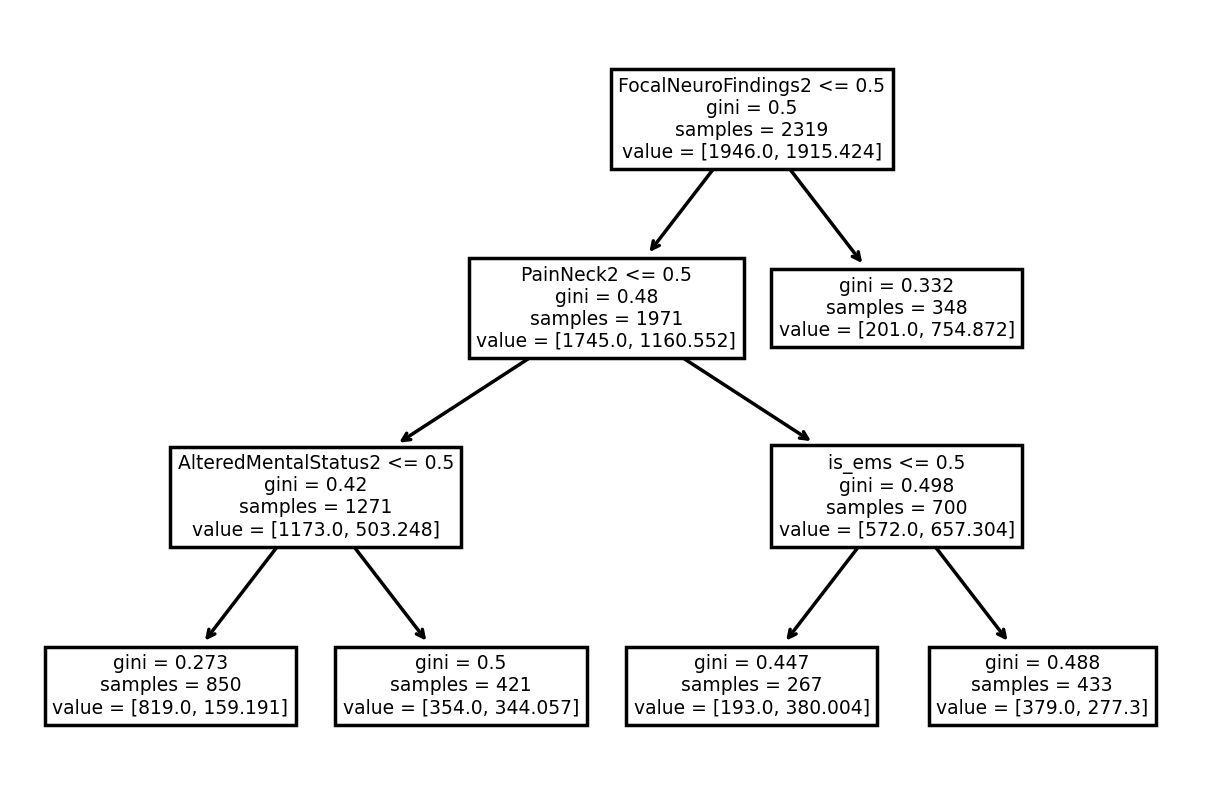

In [33]:
plot_tree(csi_models["cart"][0], feature_names=feature_names)

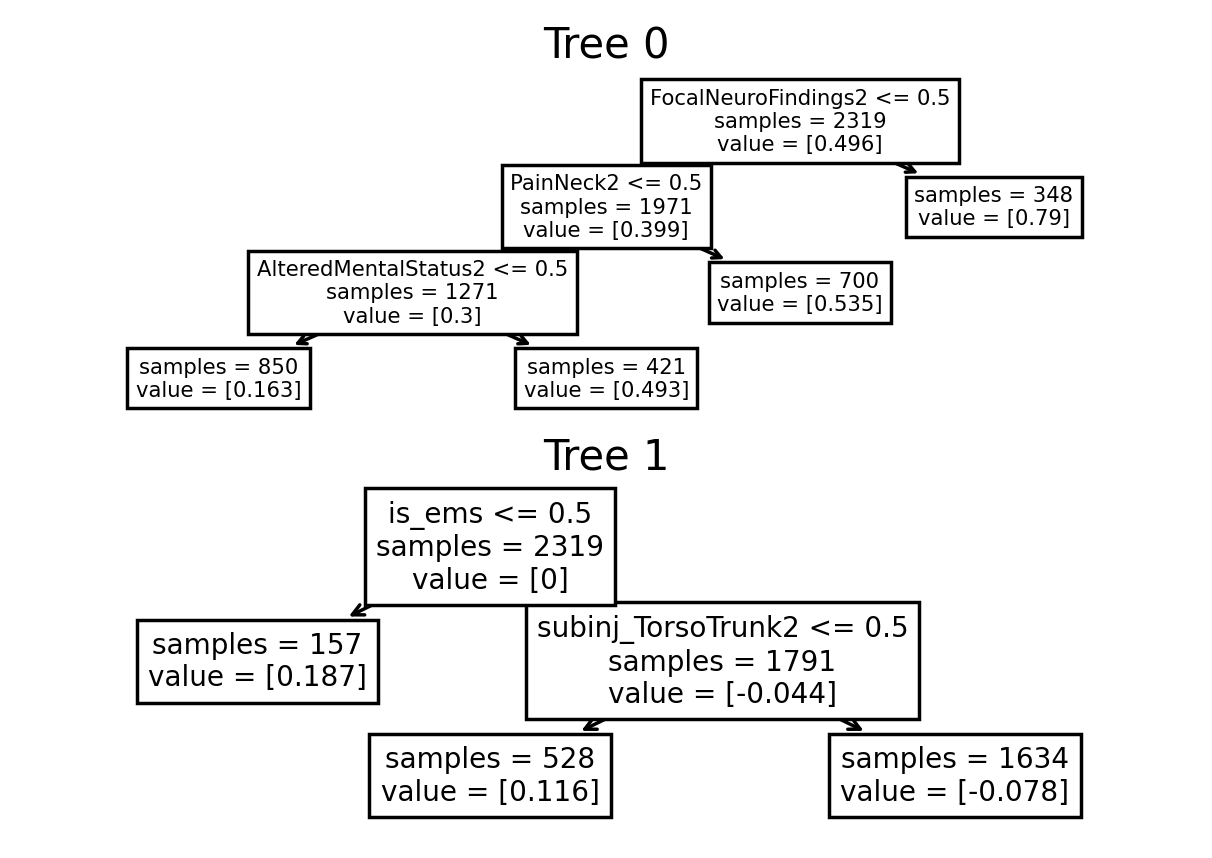

In [48]:
csi_models["figs"][0].plot(feature_names=feature_names, filename=f"plots/{dataset}.png")

# 3. TBI model

In [37]:
dataset = "tbi"
X, y, feature_names = get_clean_dataset(f'{dataset}_pecarn_pred.csv', 'imodels')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=405)
sample_weight = np.ones_like(y_train)
sample_weight[y_train == 1] = (1 - y.mean()) / y.mean()

In [38]:
tbi_models = {"figs": [],
              "cart": []}
for n_rules in rules_grid:
    m = imodels.FIGSClassifier(max_rules=n_rules)
    cart = DecisionTreeClassifier(max_leaf_nodes=n_rules)
    m.fit(X_train, y_train, feature_names=feature_names, sample_weight=sample_weight)
    cart.fit(X_train, y_train, sample_weight=sample_weight)
    tbi_models["figs"].append(m)
    tbi_models["cart"].append(cart)

In [39]:
tbi_scores = {"max_rules": rules_grid,
              "figs": [],
              "cart": []}
for idx, n_rules in enumerate(rules_grid):
    m = tbi_models["figs"][idx]
    cart = tbi_models["cart"][idx]
    figs_score = metrics.roc_auc_score(y_test, m.predict_proba(X_test)[:,1])
    cart_score = metrics.roc_auc_score(y_test, cart.predict_proba(X_test)[:,1])
    tbi_scores["figs"].append(figs_score)
    tbi_scores["cart"].append(cart_score)
pd.DataFrame(tbi_scores)

,max_rules,figs,cart
0,5,0.817931,0.801392
1,7,0.810870,0.826354
2,10,0.812634,0.821318
3,15,0.814998,0.830289


[Text(0.7142857142857143, 0.9, 'AMS <= 0.5\ngini = 0.5\nsamples = 29699\nvalue = [29442.0, 28742.989]'),
 Text(0.5714285714285714, 0.7, 'High_impact_InjSev_High <= 0.5\ngini = 0.427\nsamples = 25939\nvalue = [25836.0, 11519.564]'),
 Text(0.42857142857142855, 0.5, 'SFxBas <= 0.5\ngini = 0.343\nsamples = 22288\nvalue = [22232.0, 6263.064]'),
 Text(0.2857142857142857, 0.3, 'SFxPalp_No <= 0.5\ngini = 0.289\nsamples = 22172\nvalue = [22130.0, 4697.298]'),
 Text(0.14285714285714285, 0.1, 'gini = 0.417\nsamples = 433\nvalue = [424.0, 1006.564]'),
 Text(0.42857142857142855, 0.1, 'gini = 0.248\nsamples = 21739\nvalue = [21706.0, 3690.734]'),
 Text(0.5714285714285714, 0.3, 'gini = 0.115\nsamples = 116\nvalue = [102.0, 1565.766]'),
 Text(0.7142857142857143, 0.5, 'gini = 0.483\nsamples = 3651\nvalue = [3604.0, 5256.5]'),
 Text(0.8571428571428571, 0.7, 'gini = 0.286\nsamples = 3760\nvalue = [3606.0, 17223.426]')]

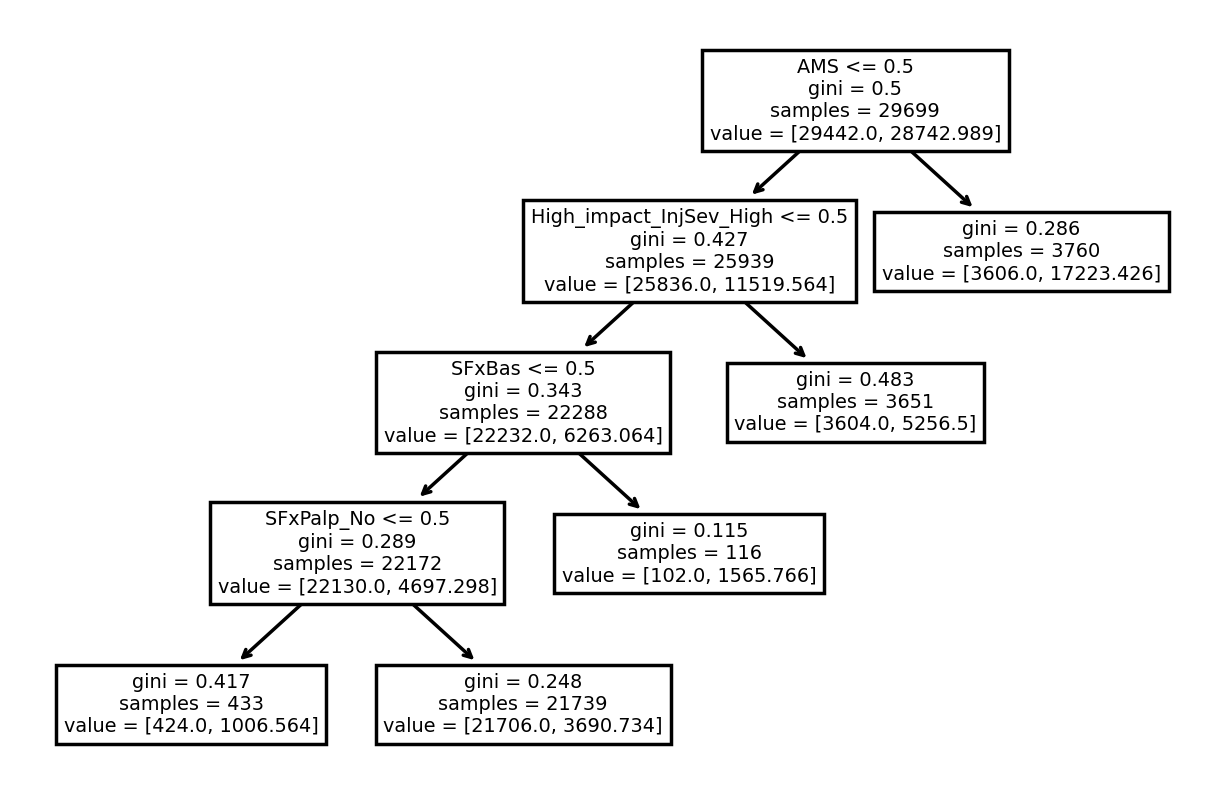

In [40]:
plot_tree(tbi_models["cart"][0], feature_names=feature_names)

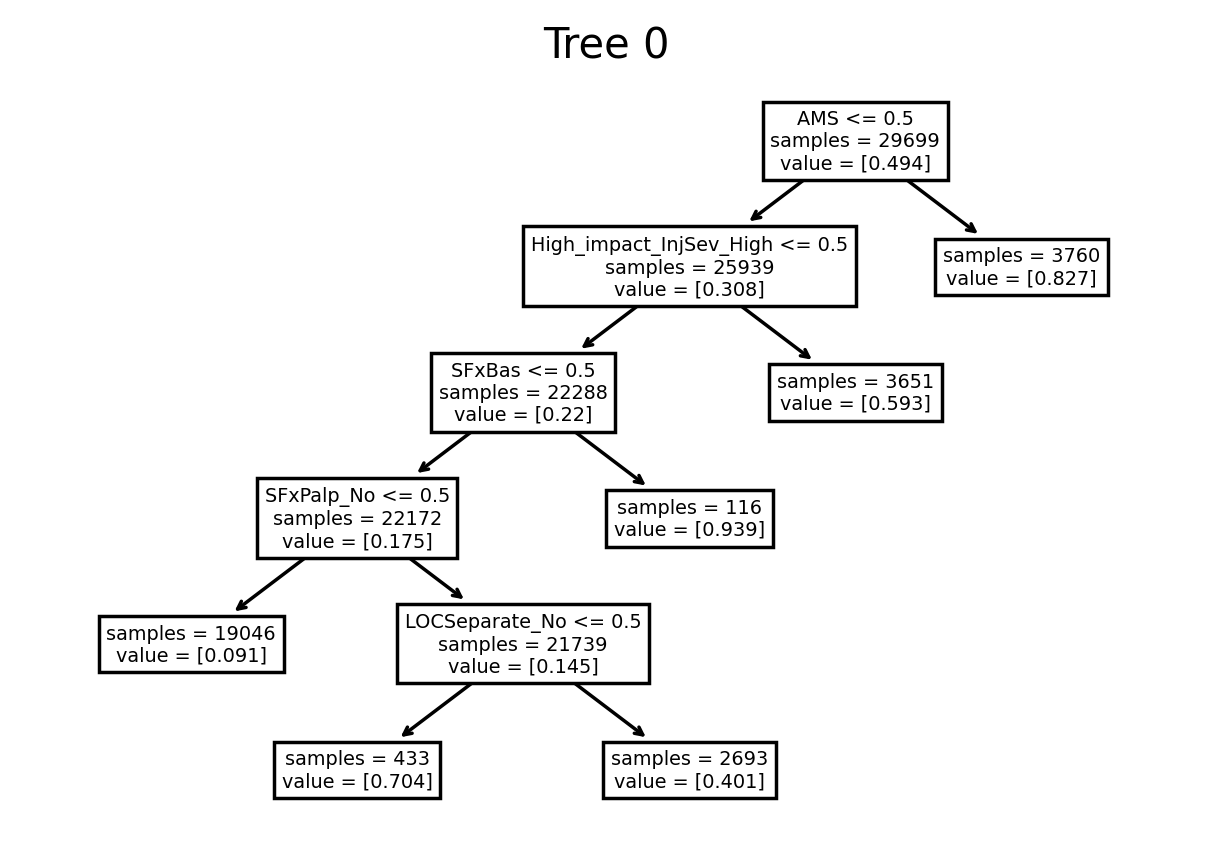

In [41]:
tbi_models["figs"][0].plot(feature_names=feature_names, filename=f"plots/{dataset}.png")